# Gera conjunto imagens original x melhores sinteticas
* pega um csv de resultado de rodada de sintese (run)
* ordenadas pelas métricas normalizadas

In [2]:
import os
import sys
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import numpy as np

['result\\old\\run_metrics.csv', 'result\\old\\run_metrics_e7057b15.csv', 'result\\run_0bca43f7ff\\run_metrics_4437042b.csv', 'result\\run_0bdd44d530\\run_metrics_1c1414c4.csv', 'result\\run_0c19639aeb\\run_metrics_149c3bb1.csv', 'result\\run_1bd1c8c771\\run_metrics_c8bb00bd.csv', 'result\\run_1d798aa5d5\\run_metrics_440d34e4.csv', 'result\\run_20250913_155213_a3ad2df0\\run_metrics_8ac7ff10.csv', 'result\\run_2ee6e81e4b\\run_metrics_75f7ec59.csv', 'result\\run_2ee6e81e4b_1\\run_metrics_50dc01c1.csv', 'result\\run_2ee6e81e4b_2\\run_metrics_9ce11385.csv', 'result\\run_3ce657b8f7\\run_metrics_19bd129f.csv', 'result\\run_5f43816c42\\run_metrics_cc9b30a2.csv', 'result\\run_5f43816c42_1\\run_metrics_5f43816c42.csv', 'result\\run_5f43816c42_2\\run_metrics_5f43816c42.csv']


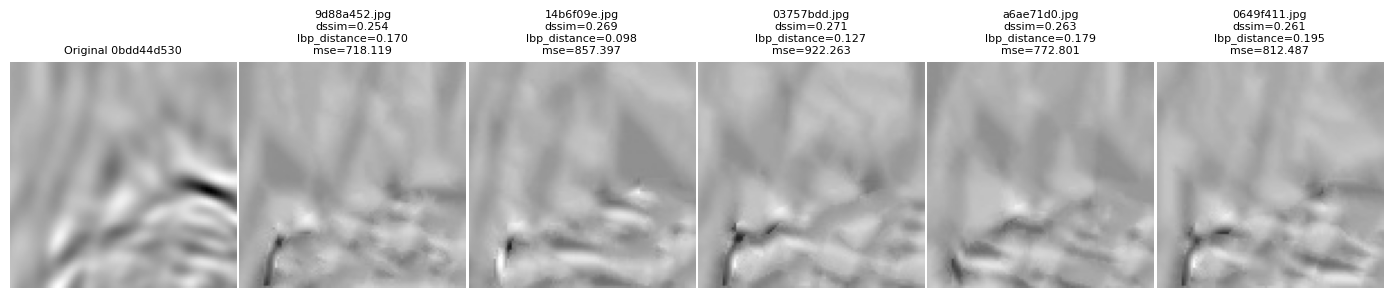

In [10]:
#* Selecione path do arquivo contendo 1d798aa5d5
cols=5
names = ['3ce657b8f7', '1d798aa5d5', '1bd1c8c771', '0bdd44d530']
sampleName = '0bdd44d530'  # ajuste conforme necessário
base_dir = f'result/run_{sampleName}'  # ajuste conforme necessário

#liste todos arqvuios run_metrics csv na pasta result e seus subdiretorios
arquivos = []
for root, dirs, files in os.walk('result'):
    for f in files:
        if f.startswith('run_') and f.endswith('.csv'):
            arquivos.append(os.path.join(root, f))
print(arquivos)
#Selecione o arquivo contendo 1d798aa5d5
arquivos = [f for f in arquivos if sampleName in f]
meuarquivo=arquivos[0]
meuarquivo
#* Lê arquivo
# Lê ignorando linhas de comentário (começam com #) e usando separador ponto-e-vírgula
df = pd.read_csv(meuarquivo, sep=';', comment='#')
#* normaliza
# Cria colunas normalizadas (0..1) e uma coluna ponderada combinando dssim e lbp_distance
# Requisitos: DataFrame df já carregado com colunas 'dssim' e 'lbp_distance'
# Ajuste os pesos conforme a importância de cada métrica (devem somar 1)
w_dssim = 0.5  # mais peso para dssim
w_lbp   = 0.5
assert abs((w_dssim + w_lbp) - 1.0) < 1e-9, "Os pesos devem somar 1"

def minmax_norm(series):
    s_min = series.min()
    s_max = series.max()
    if pd.isna(s_min) or pd.isna(s_max):
        return pd.Series([0.0]*len(series), index=series.index)
    rng = s_max - s_min
    if rng == 0:
        return pd.Series([0.0]*len(series), index=series.index)
    return (series - s_min) / rng

# Normalizações (0 = melhor porque são distâncias)
df['dssim_norm']        = minmax_norm(df['dssim'])
df['lbp_distance_norm'] = minmax_norm(df['lbp_distance'])

# Distância ponderada (0 melhor, 1 pior)
df['weighted_distance'] = w_dssim * df['dssim_norm'] + w_lbp * df['lbp_distance_norm']
# Similaridade derivada (1 melhor, 0 pior)
df['weighted_similarity'] = 1.0 - df['weighted_distance']

# Visualiza primeiras linhas
cols_show = ['dssim','dssim_norm','lbp_distance','lbp_distance_norm','weighted_distance','weighted_similarity']
df[cols_show].head()
#* ordena df e copia para sorted_df
# Ordena pelo menor weighted_distance (melhor) e cria ranking
if 'weighted_distance' not in df.columns:
    raise RuntimeError("Coluna 'weighted_distance' não encontrada. Execute a célula de normalização antes.")

sorted_df = df.sort_values('weighted_distance', ascending=True).reset_index(drop=True)
# Cria coluna de ranking começando em 1
sorted_df['rank_weighted'] = sorted_df['weighted_distance'].rank(method='first', ascending=True).astype(int)

# Mostra top 15
cols_show = [c for c in ['rank_weighted','output_file','dssim','lbp_distance','dssim_norm','lbp_distance_norm','weighted_distance','weighted_similarity'] if c in sorted_df.columns]
# Substitui o caminho em 'output_file' pelo nome do arquivo (sem diretórios)
sorted_df['nome_arquivo'] = sorted_df['output_file'].apply(lambda x: os.path.basename(x))
sorted_df[cols_show].head(4)

subset_imgs = sorted_df.head(5)

# --------------------------------------------

original_img_path = os.path.join('tgs_salt', f'{sampleName}.png')  # ajuste conforme necessário
original_img = cv2.imread(original_img_path)
if original_img is None:
    print(f"Não foi possível ler a imagem original: {original_img_path}")

fig, axes = plt.subplots(1, cols + 1, figsize=((cols + 1) * 2.3, 2.6))
if cols + 1 == 1:
    axes = [axes]


# Mostra a imagem original no primeiro eixo
if original_img is None:
    axes[0].imshow(np.zeros((64,64,3), dtype=np.uint8))
    axes[0].set_title('Original\n(Não encontrada)', fontsize=8)
else:
    if len(original_img.shape) == 2:
        axes[0].imshow(original_img, cmap='gray')
    else:
        axes[0].imshow(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB))
    axes[0].set_title(f'Original {sampleName}', fontsize=8)
axes[0].axis('off')

# Mostra as imagens sintetizadas
for ax, (_, row) in zip(axes[1:], subset_imgs.iterrows()):
    img_path = os.path.join(base_dir, row['nome_arquivo'])
    img = cv2.imread(img_path)
    if img is None:
        print(f"Não foi possível ler: {img_path}")
        ax.imshow(np.zeros((64,64,3), dtype=np.uint8))
    else:
        if len(img.shape) == 2:
            ax.imshow(img, cmap='gray')
        else:
            ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    dssim = row.get('dssim', None)
    lbp = row.get('lbp_distance', None)
    mse = row.get('mse', None)
    title_parts = []
    title_parts.append(row['nome_arquivo'])
    if dssim is not None:
        title_parts.append(f"dssim={dssim:.3f}")
    if lbp is not None:
        title_parts.append(f"lbp_distance={lbp:.3f}")
    if mse is not None:
        title_parts.append(f"mse={mse:.3f}")

    ax.set_title('\n'.join(title_parts), fontsize=8)
    ax.axis('off')

plt.tight_layout(pad=0.2, w_pad=0.1, h_pad=0.1)
plt.show()


In [25]:
#liste todas iamgens na pasta docs/sint


docs_sint_dir = '_docs/sint'
imagems = [f for f in os.listdir(docs_sint_dir) if f.endswith('.png')]


In [26]:
#reverta a ordem de imagems
imagems = imagems[::-1]
imagems

['3ce657b8f7.png', '1d798aa5d5.png', '1bd1c8c771.png', '0bdd44d530.png']

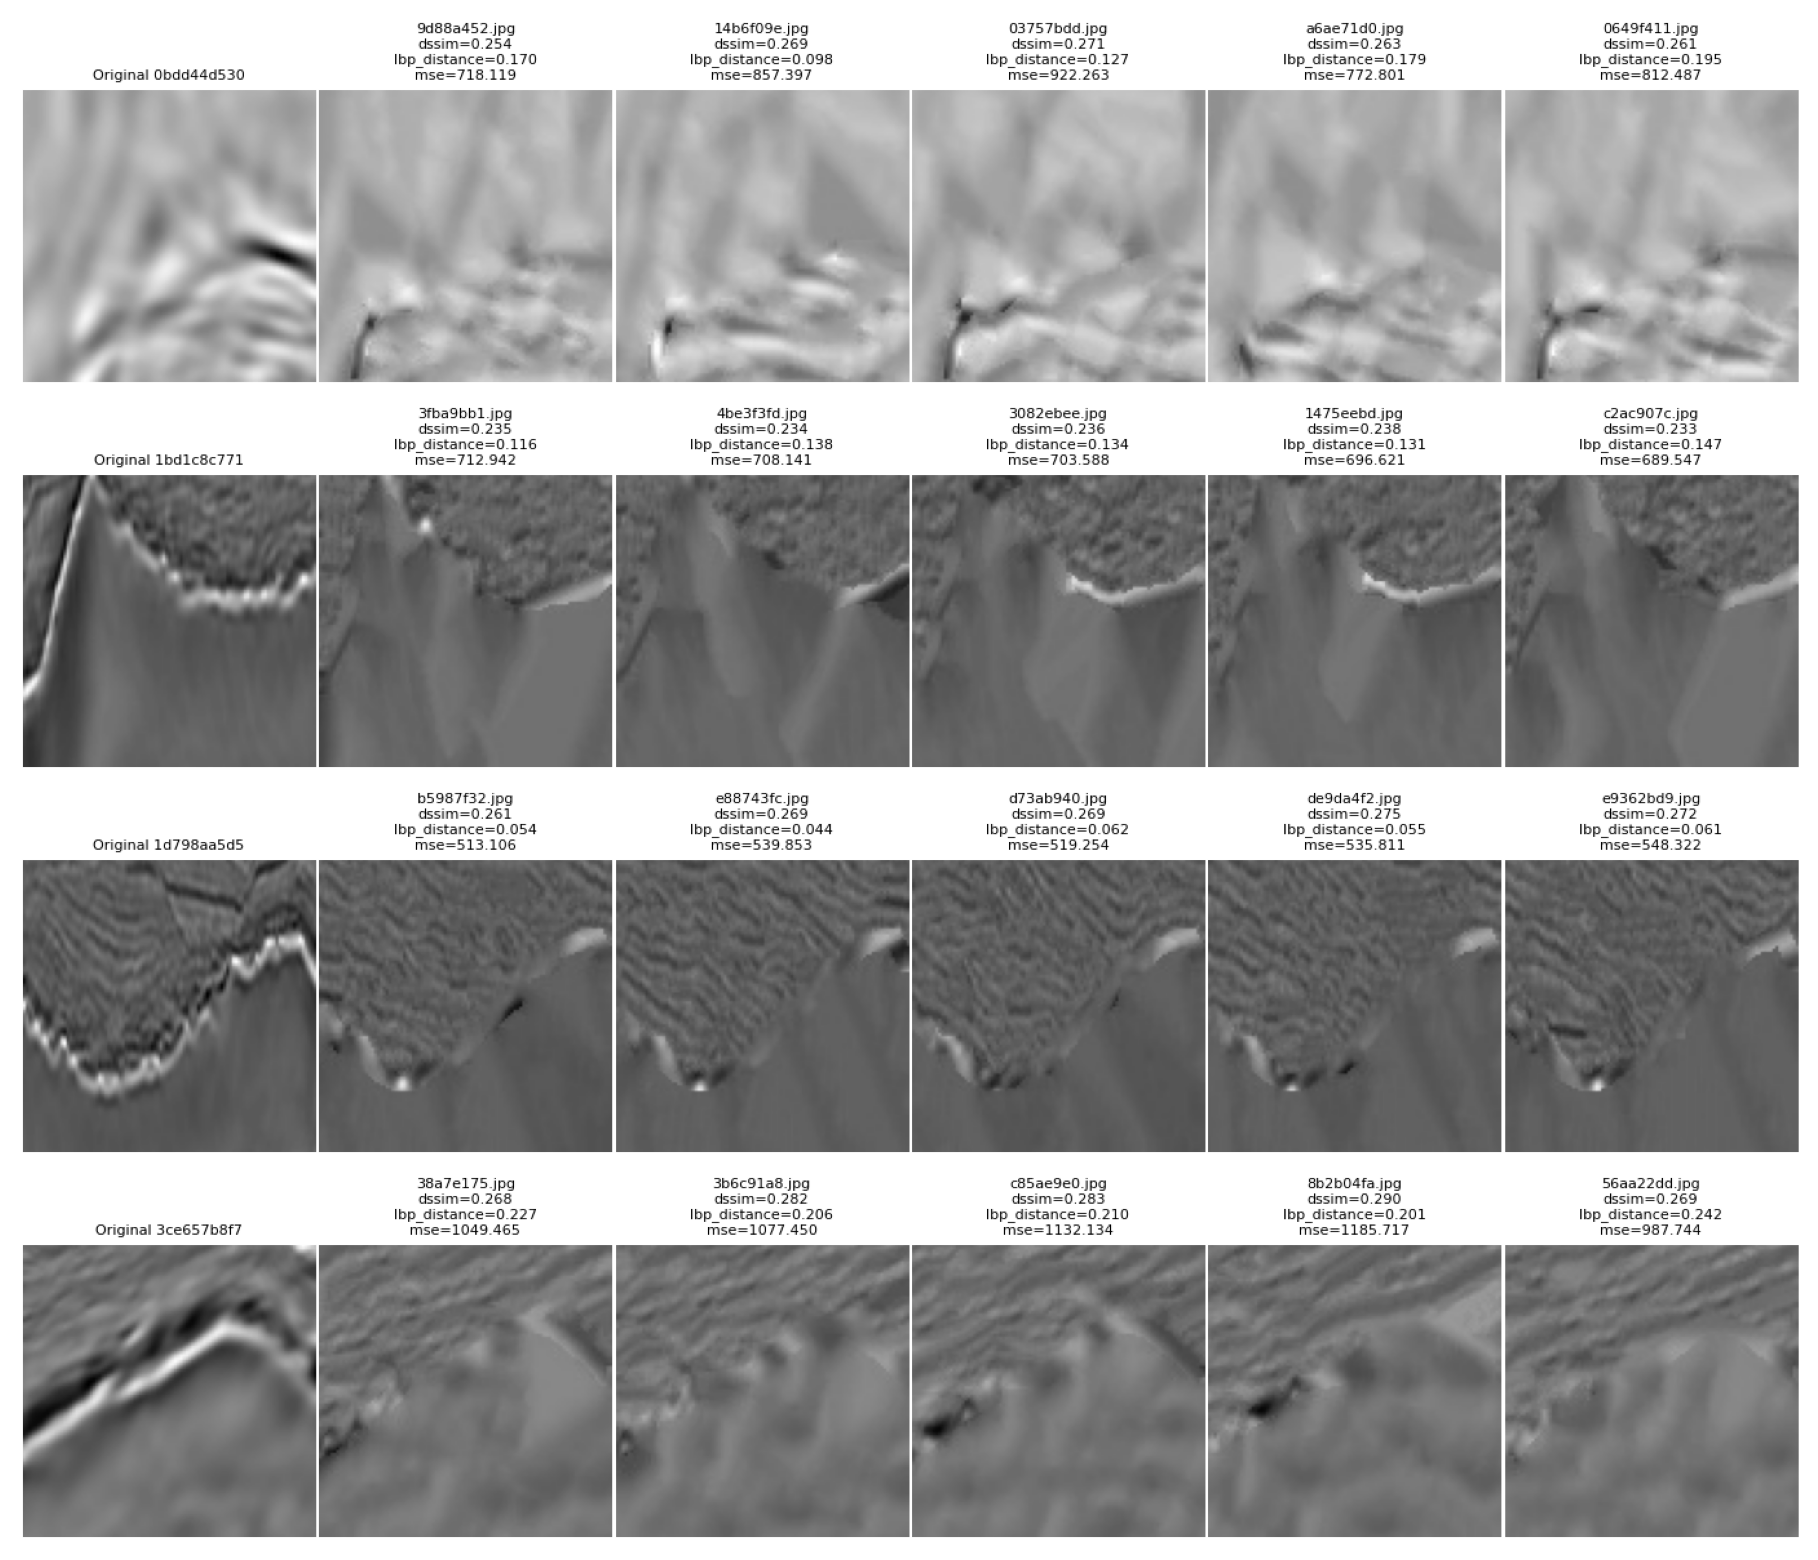

In [27]:
#agrupe todas as imagens em uma única imagem uma embaixo da outra
#inverta a ordem das imagens em imgs

imgs = [cv2.imread(os.path.join(docs_sint_dir, f)) for f in imagems]

#mostre a imagem agrupada

plt.figure(figsize=(40, 20))
plt.imshow(cv2.cvtColor(combined_img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()